In [45]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import re
from utils import *
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import homogeneity_score
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/U.S._Chronic_Disease_Indicators__CDI_.csv")
df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2015,2015,US,United States,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,59,ALC,ALC8_0_2,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
1,2012,2012,DC,District of Columbia,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,11,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2012,2012,GU,Guam,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,66,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2012,2012,PR,Puerto Rico,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,72,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
4,2012,2012,US,United States,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,59,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN


# Keep only the unique questions

In [4]:
df = df[~df.duplicated("Question", keep="first")][["Topic", "Question"]].reset_index(drop=True)
df.head()

,Topic,Question
0,Alcohol,Amount of alcohol excise tax by beverage type ...
1,Alcohol,Amount of alcohol excise tax by beverage type ...
2,Alcohol,Amount of alcohol excise tax by beverage type ...
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...


# Breakdown of questions' topics

In [5]:
topics = df["Topic"].value_counts()
topics

Nutrition, Physical Activity, and Weight Status    37
Diabetes                                           20
Cancer                                             20
Cardiovascular Disease                             18
Chronic Obstructive Pulmonary Disease              16
Overarching Conditions                             16
Tobacco                                            16
Alcohol                                            16
Arthritis                                          10
Asthma                                              9
Oral Health                                         9
Older Adults                                        4
Chronic Kidney Disease                              4
Mental Health                                       3
Reproductive Health                                 3
Immunization                                        1
Disability                                          1
Name: Topic, dtype: int64

# Filter out categories with few entries

In [6]:
df = df[df["Topic"].str.match("|".join(topics.nlargest(11).index.to_list()))].reset_index(drop=True)
df.head()

,Topic,Question
0,Alcohol,Amount of alcohol excise tax by beverage type ...
1,Alcohol,Amount of alcohol excise tax by beverage type ...
2,Alcohol,Amount of alcohol excise tax by beverage type ...
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...


In [7]:
_, __, word_to_vec = read_glove_vecs("GloVe/glove.6B.200d.txt")

In [8]:
unk = np.zeros(word_to_vec["a"].shape)
for emb in word_to_vec.values():
    unk += emb
unk = unk / len(word_to_vec)
word_to_vec["<unk>"] = unk

In [12]:
def question_to_vec(question):
    split = lambda x: re.findall(r"[\w']+|[.,!?;]", x.lower()) if x is not None else []
    embedding = np.zeros(word_to_vec["a"].shape)
    words = split(question)
    for word in words:
        if word in word_to_vec:
            embedding += word_to_vec[word]
        else:
            embedding += word_to_vec["<unk>"]
    return embedding/len(words)
embeddings = df["Question"].apply(question_to_vec).to_list()

In [13]:
pca_2d = PCA(n_components=2)
coords = pca_2d.fit_transform(embeddings)
coords.shape

(187, 2)

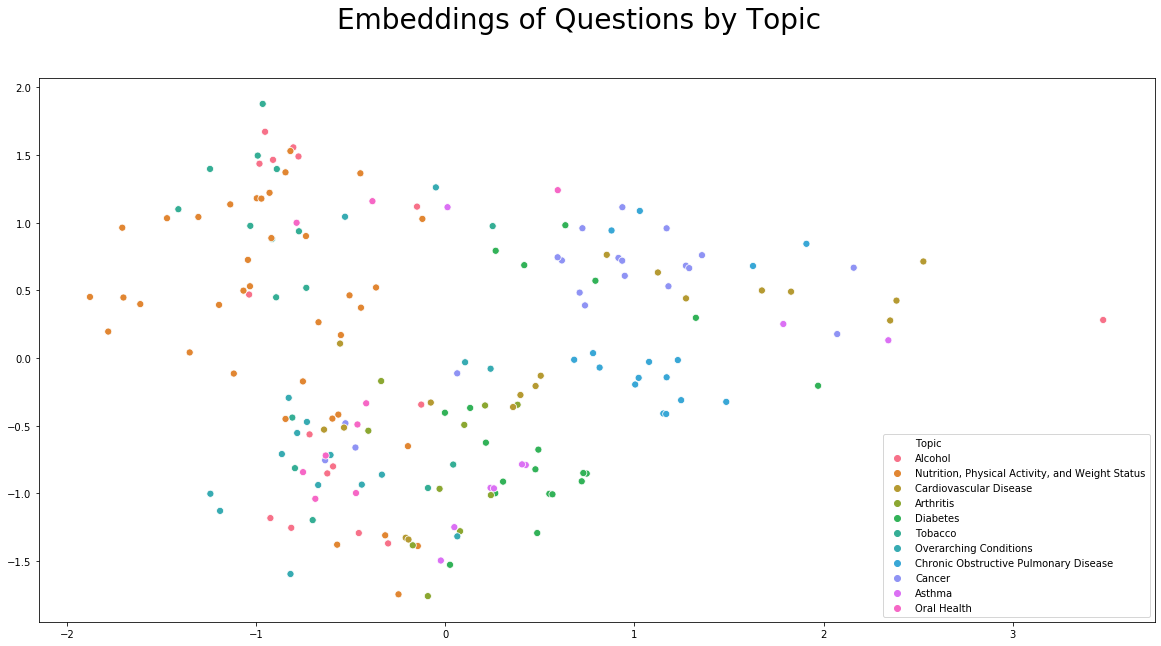

In [14]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Embeddings of Questions by Topic", fontsize=28)
sns.scatterplot(coords[:,0], coords[:,1], hue=df["Topic"], s=50)

In [15]:
pca = PCA(n_components=25)
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'variance')

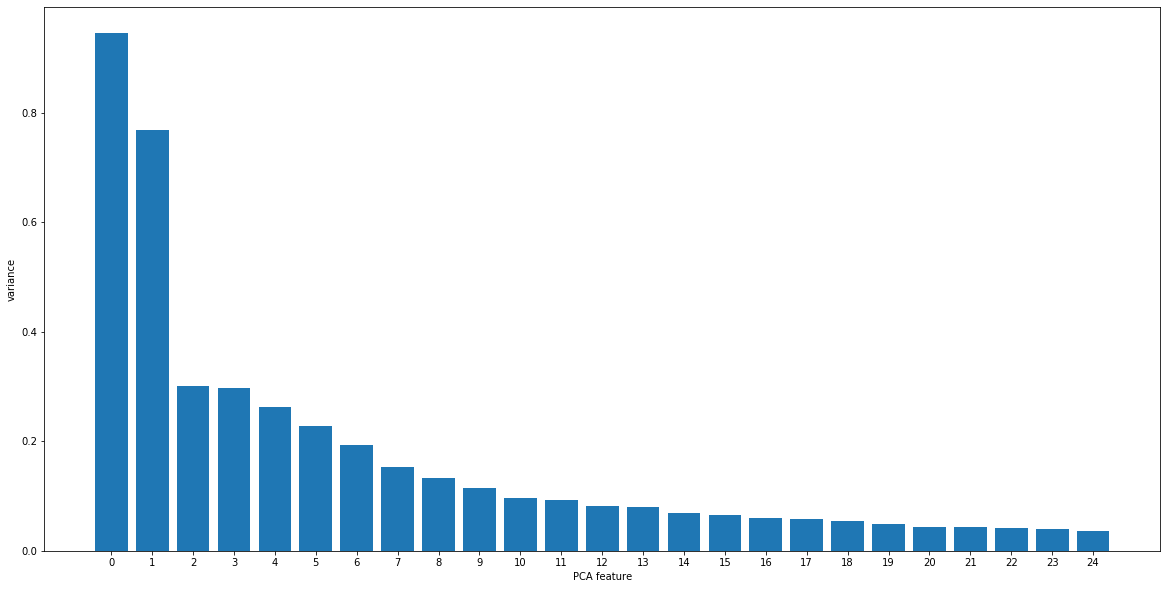

In [16]:
features = range(pca.n_components_)
plt.figure(figsize=(20, 10))
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.xlabel('PCA feature')
plt.ylabel('variance')

,# of components,Inertia


In [51]:
distribution = []
for j in range(100):
    avg_params 
    params = pd.DataFrame(columns=["# of components", "Inertia", "Homogeneity Score"])
    for i in range(1, 26):
        pca = PCA(n_components=i)
        kmeans = KMeans(n_clusters=11)
        steps = [("pca", pca), ("kmeans", kmeans)]
        pipeline = Pipeline(steps)
        pipeline.fit(embeddings)
        params.loc[i-1] = [i, kmeans.inertia_, homogeneity_score(df["Topic"], pipeline.predict(embeddings))]
    distribution.append(params["Homogeneity Score"].idxmax())

(array([ 6.,  9.,  5.,  9., 10., 14., 11., 15., 10., 11.]),
 array([ 5. ,  6.9,  8.8, 10.7, 12.6, 14.5, 16.4, 18.3, 20.2, 22.1, 24. ]),
 <a list of 10 Patch objects>)

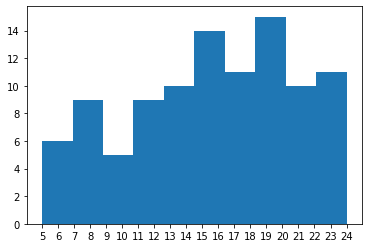

In [59]:
plt.xticks(range(5, 25))
plt.hist(distribution)

In [43]:
pca = PCA(n_components=1)
kmeans = KMeans(n_clusters=11)
steps = [("pca", pca), ("kmeans", kmeans)]
pipeline = Pipeline(steps)
pipeline.fit(embeddings)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=1,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=11, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [44]:
df["cluster"] = pipeline.predict(embeddings)
df

,Topic,Question,cluster
0,Alcohol,Amount of alcohol excise tax by beverage type ...,1
1,Alcohol,Amount of alcohol excise tax by beverage type ...,5
2,Alcohol,Amount of alcohol excise tax by beverage type ...,1
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years,0
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...,0
...,...,...,...
182,"Nutrition, Physical Activity, and Weight Status",Farmers markets that accept Women and Infant C...,1
183,Oral Health,Population served by community water systems t...,1
184,"Nutrition, Physical Activity, and Weight Status",Presence of regulations pertaining to serving ...,5
185,Oral Health,Dental visits among children and adolescents a...,1
